# POINT objects and hulls with 🌲 Perth city trees 🌳

- Lets look at a POINT dataset
  - Our data is [Trees in the city](https://catalogue.data.wa.gov.au/dataset/perth-trees-in-the-city)
- and explore some useful algorithms:
  - convex and concave hulls
  - plotting colours 🌈
  - distance to hub (maybe)

In [1]:
# the usual suspects
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# geopandas for geospatial muning and visuals
import geopandas as gpd
# library for accessing map raster tiles
import contextily as ctx
# shapely objects and tools
from shapely.geometry import Point

# import the data
city_trees = gpd.read_file('./../data/Trees_in_the_City.geojson')

OBJECTID  TREE_ID              DATE_PLANTED SUBURB  \
0         1     1918 2007-08-08 00:00:00+00:00  PERTH   
1         3     1920 1900-01-01 00:00:01+00:00  Perth   
2         4     1921 1900-01-01 00:00:01+00:00  Perth   
3         5     1922 1900-01-01 00:00:01+00:00  Perth   
4         6     1923 1900-01-01 00:00:01+00:00  Perth   

                  BOTANICAL_NAME          COMMON_NAME         FAMILY  \
0              Quercus palustris              Pin Oak       Fagaceae   
1            Cinnamomum camphora       Camphor Laurel      Lauraceae   
2         Araucaria heterophylla  Norfolk Island Pine  Araucariaceae   
3  Ficus microcarpa var 'Hillii'            Hills Fig       Moraceae   
4  Ficus microcarpa var 'Hillii'            Hills Fig       Moraceae   

   TREE_HEIGHT RARE_SPECIES HISTORIC_SIGNIFICANCE COMMUNITY_SIGNIFICANCE  \
0          1.5           No                    No                     No   
1          NaN           No                    No                     No   
2          NaN           No                    No                     No   
3          NaN           No                    No                     No   
4          NaN           No                    No                     No   

  SIGNIFICANT_GROUP RETIRED                     geometry  
0                No    None  POINT (115.86178 -31.95858)  
1                No    None  POINT (115.86186 -31.95871)  
2                No    None  POINT (115.86168 -31.95895)  
3                No    None  POINT (115.86169 -31.95912)  
4                No    None  POINT (115.86184 -31.95901)

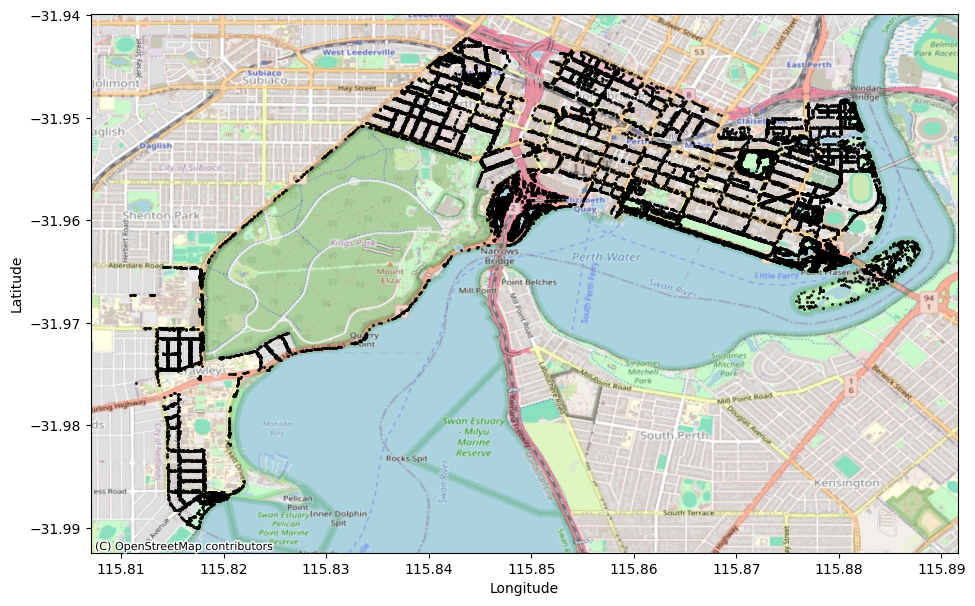

In [2]:
display(city_trees.head())

def plot_city_trees(ax
                    ,color:str|None="black"
                    ,column:str|None=None):
    city_trees.plot(ax=ax
                    ,color=color
                    ,column=column
                    ,markersize=1)
    ctx.add_basemap(ax
        ,crs=city_trees.crs.to_string()
        ,source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.get_xaxis().get_major_formatter().set_useOffset(False)

fig, ax = plt.subplots(figsize=(18,7))
plot_city_trees(ax)

# Draw a box around those points

- Often useful to draw boxes or polygons around your points
- We have two algorithms for this:
  - `Convex hull`:
    - draw a polygon with no inny bits.
  - `Concave hull`:
    - *laise faire* convex hull with inny bits and holes.

## First, a box.

- Get the bounds from the geopandas object. Draw a polygon and plot it.

<AxesSubplot: xlabel='Longitude', ylabel='Latitude'>

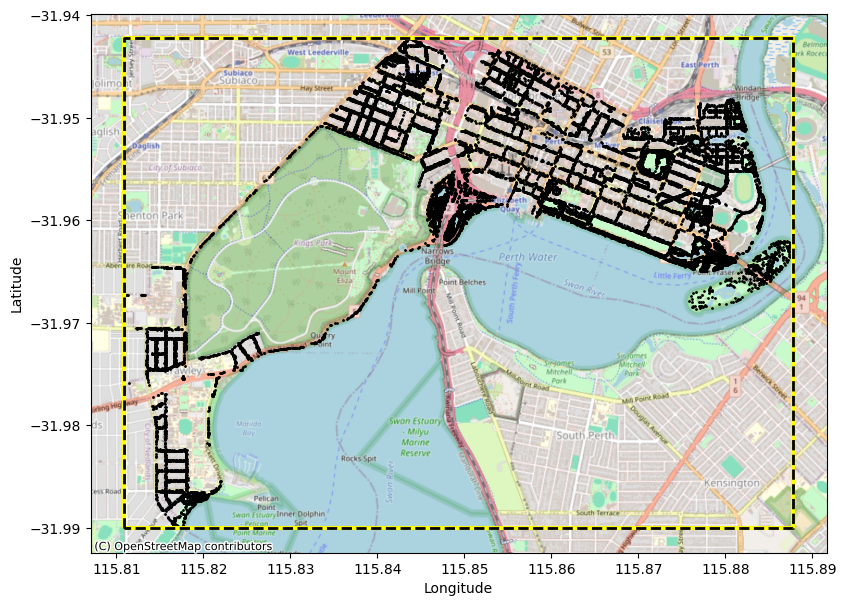

In [3]:
from shapely.geometry import Polygon # need a polygon here

bounds = city_trees.total_bounds
city_trees_box = Polygon([(bounds[0], bounds[1]),
                        (bounds[0], bounds[3]),
                        (bounds[2], bounds[3]),
                        (bounds[2], bounds[1])])
# convert to geodataframe for plotting
city_trees_box_gdf = gpd.GeoDataFrame(geometry=[city_trees_box], crs=city_trees.crs)

fig, ax = plt.subplots(figsize=(18,7))
plot_city_trees(ax)
city_trees_box_gdf.boundary.plot(ax=ax
                                ,color='yellow'
                                ,linewidth=3)
city_trees_box_gdf.boundary.plot(ax=ax
                                ,color='black'
                                ,linewidth=2
                                ,linestyle='dashed')

## Convex Hull

- We use `unary_union` here to combine all the points together.
- Otherwise it will do a convex hull for every point seperately...

In [4]:
city_trees_hull = city_trees.unary_union.convex_hull
fig, ax = plt.subplots(figsize=(18,7))
plot_city_trees(ax)
gpd.GeoSeries([city_trees_hull]).boundary.plot(ax=ax, color='yellow', linewidth=3)

<AxesSubplot: xlabel='Longitude', ylabel='Latitude'>

- And we can use groupby to do the hull by each suburb.
- Checkout some of the weird suburbs in there... 😂
  - And the Crawley hull is a little bit suspect 🤔

In [5]:
city_trees["SUBURB"] = city_trees["SUBURB"].str.title()
convex_rare_species = (
    city_trees
    .groupby("SUBURB")
    .apply(lambda df: df.geometry.unary_union.convex_hull))

convex_rare_species_gdf = gpd.GeoDataFrame(
    geometry=convex_rare_species
    ,crs=city_trees.crs) # type: ignore
convex_rare_species_gdf.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(18,7))
plot_city_trees(ax,column="SUBURB",color=None)
convex_rare_species_gdf.plot(column="SUBURB"
                            ,facecolor="none"
                            ,legend=True
                            ,legend_kwds={'loc': 'upper left'}
                            ,linewidth=3
                            ,ax=ax)

/tmp/ipykernel_12753/4048449099.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.geometry.unary_union.convex_hull))


<AxesSubplot: xlabel='Longitude', ylabel='Latitude'>

# Concave Hull

⚠️ spicy danger zone 🌶️

- Concave hull allows for more complex groupings
- But can produce some consequences.
- `concave_hull` also acts on each row and not the whole df.
- So we have to get the union of all points and get that polygon
- `ratio` is the argument of interest here:
  - as we decrease ratio the concave hull gets "more concave"
  - but the splits between hulls become a bit strange...

In [6]:
all_city_trees_points = city_trees.unary_union
all_city_trees_points_gdf = gpd.GeoDataFrame(
    geometry=[all_city_trees_points]
    ,crs=city_trees.crs) # type: ignore
concave_polys = []
ratios = [1,0.5,0.35,0.2,0.01]
for i in ratios:
    concave_polys.append(
        all_city_trees_points_gdf.concave_hull(ratio=i)[0])
concave_polys_gdf = gpd.GeoSeries(concave_polys).to_frame()
concave_polys_gdf["ratio"] = ratios

fig, ax = plt.subplots(figsize=(18,7))
plot_city_trees(ax)
concave_polys_gdf.plot(column="ratio"
                        ,facecolor="none"
                        ,legend=True
                        ,cmap="Spectral"
                        ,linewidth=2
                        ,ax=ax)

<AxesSubplot: xlabel='Longitude', ylabel='Latitude'>

In [7]:
city_trees["geometry"].concave_hull()

0        POINT (115.86178 -31.95858)
1        POINT (115.86186 -31.95871)
2        POINT (115.86168 -31.95895)
3        POINT (115.86169 -31.95912)
4        POINT (115.86184 -31.95901)
                    ...             
16470    POINT (115.81452 -31.97966)
16471    POINT (115.84045 -31.95043)
16472    POINT (115.84060 -31.95047)
16473    POINT (115.87353 -31.96293)
16474    POINT (115.87334 -31.96324)
Length: 16475, dtype: geometry

# Distance to hub

TBD. If we have time can just do it live.